In [1]:
import os
import random
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor
import optuna
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV
from scipy.optimize import minimize

from library.Data_Preprocessing import Balance_Ratio, training_def
from library.Imbalance_Sampling import label_divide, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## Function Definition

### CatBoost

In [2]:
# classifier
def CatBoostC(train_x, test_x, train_y, test_y, config, return_prob = False):
    
    clf = CatBoostClassifier(**config, verbose = 0)
    clf.fit(train_x, train_y)
    predict_y = clf.predict(test_x)
    define_predict = (predict_y > 0.5).astype(int)
    if return_prob:
        result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    else:
        result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result


# regressor (optional)
def CatBoostR(train_x, test_x, train_y, test_y, config):
    
    reg = CatBoostRegressor(**config, verbose = 0)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result


# classifier for all resampling datasets
def runall_CatBoostC(trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    set_index = list(config.keys())
    judge = set_index[0]

    for i, j in tqdm(enumerate(set_index)):
        print('\n', f'Data{j}:')
        if isinstance(config[judge], dict) :
            best_config = config[j]
        else :
            best_config = config
        
        result = CatBoostC(trainset_x[j], test_x, trainset_y[j], test_y, best_config)
        table = cf_matrix(result, trainset_y[j])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'data{j}'})

    return table_set


# regressor for all resampling datasets (optional)
def runall_CatBoostR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = CatBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### Probability Calibration (optional)

In [ ]:
def beta_map(s, a, b, c):
    return 1 / (1 + 1 / (np.power(np.exp(1), c)*(np.power(s, a) / np.power(1-s, b))))
                

def self_loss(three, test_y, predict_y):
    a, b, c = three
    new_s = beta_map(predict_y, a, b, c)
    loss = np.mean(test_y*np.log(new_s) + (1 - test_y)*np.log(1 - new_s))*(-1)
    return loss


def stratified_data(train_data, cv):
    
    good = train_data[train_data.GB == 0]
    bad = train_data[train_data.GB == 1]
    good_index = random.sample(good.index.to_list(), k = len(good))
    bad_index = random.sample(bad.index.to_list(), k = len(bad))
    
    train_x_dict = {}
    train_y_dict = {}
    valid_x_dict = {}
    valid_y_dict = {}
    for i in range(cv):
        
        if (i+1) == cv:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))): ]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))): ]
        else:
            good_valid_index = good_index[int(np.floor((i/cv)*len(good))) : int(np.floor(((i+1)/cv)*len(good)))]
            bad_valid_index = bad_index[int(np.floor((i/cv)*len(bad))) : int(np.floor(((i+1)/cv)*len(bad)))]
        good_train_index = [x for x in good_index if x not in good_valid_index]
        bad_train_index = [x for x in bad_index if x not in bad_valid_index]
        
        good_train = good.loc[good_train_index]
        good_valid = good.loc[good_valid_index]
        bad_train = bad.loc[bad_train_index]
        bad_valid = bad.loc[bad_valid_index]
        train = pd.concat([good_train, bad_train], axis = 0)
        valid = pd.concat([good_valid, bad_valid], axis = 0)
        train_x_dict[i], train_y_dict[i], valid_x_dict[i], valid_y_dict[i] = label_divide(train, valid, train_only = False)

    return train_x_dict, train_y_dict, valid_x_dict, valid_y_dict


def cali_CatBoostC(train_x, train_y, test_x, test_y, config, method):
    
    clf = CatBoostClassifier(**config, silent = True)
    cali_clf = CalibratedClassifierCV(clf, method = method, cv = 5)
    cali_clf.fit(train_x, train_y)
    predict_y = cali_clf.predict_proba(test_x)[:, 1]
    predict = (predict_y > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})
    
    return result 


def beta_CatBoostC(train_x, train_y, test_x, test_y, config, loss_function = self_loss):
    
    train = pd.concat([train_x, train_y], axis = 1)
    train_x_dict, train_y_dict, valid_x_dict, valid_y_dict = stratified_data(train, cv = 5)
    
    cali_param = {}
    for i in range(len(train_x_dict)):
        clf = CatBoostClassifier(**config, silent = True)
        clf.fit(train_x_dict[i], train_y_dict[i])
        predict_y = clf.predict_proba(valid_x_dict[i])[:, 1]
        mini_result = minimize(loss_function, [0.5, 0.5, 0.5], (valid_y_dict[i], predict_y))
        cali_param[i] = mini_result.x
        
    clf = CatBoostClassifier(**config, silent = True)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    
    cali_predict = np.array(0).astype(float)
    for i in range(len(cali_param)):
        cali_result = beta_map(predict_y, *cali_param[i])
        cali_predict = cali_predict + cali_result
    cali_predict /= len(cali_param)
      
    predict = (cali_predict > 0.5).astype(int)
    result = pd.DataFrame({'truth': test_y, 'predict': predict})

    return result


def all_cali_CatBoostC(trainset_x, trainset_y, test_x, test_y, config_dict, method):
    
    keys = config_dict.keys()
    all_result = pd.DataFrame()
    for i in keys:
        print('\n', f'Data{i}:')
        
        if method in ['isotonic', 'sigmoid']:
            table = cali_CatBoostC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i], method)
        elif method == 'beta':
            table = beta_CatBoostC(trainset_x[i], trainset_y[i], test_x, test_y, config_dict[i])
        result_df = cf_matrix(table, trainset_y[i])
        all_result = pd.concat([all_result, result_df], axis = 0).rename(index = {0: f'data{i}'})
        
    return all_result

### Optuna

In [3]:
# creator of optuna study for CatBoost
def CatBoost_creator(train_data, mode, num_valid = 5, label = 'GB') :

    def objective(trial) :
    
        param_1 = {
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            'iterations': trial.suggest_categorical('iterations', [100, 300, 500]),
            'depth': trial.suggest_int('depth', 2, 12, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10) 
        }

        if param_1['grow_policy'] == 'Depthwise' :
            param_2 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 60, step = 5)
            }
            param = {**param_1, **param_2}
        
        elif param_1['grow_policy'] == 'Lossguide' :
            param_3 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 60, step = 5),
                'max_leaves': trial.suggest_int('max_leaves', 10, 50, step = 5)
            }
            param = {**param_1, **param_3}
        
        else :
            param = param_1

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = CatBoostC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 1
                if recall.values > 0:
                    fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision) 
                else:
                    fscore = 0
                result_list.append(fscore)

            elif mode == 'R':
                result = CatBoostR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

### Full Experiment

In [4]:
def full_catboost(train_month, times):
    best_param = dict()
    all_score = dict()
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    #  do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, final_br = 1, num_os = 10)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)

        # searching for hyperparameters
        best_param[i], all_score[i] = all_optuna(all_data = all_train, 
                                         mode = 'C', 
                                         TPE_multi = False, 
                                         n_iter = 25, 
                                         filename = f'runhist_array_m2m4_m5_3criteria_CatBoost_{i}',
                                         creator = CatBoost_creator
                                        )
        # store the probability predicted by the classifier 
        for j in best_param[i].keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            table = CatBoostC(all_train_x[j], all_test_x, all_train_y[j], all_test_y, best_param[i][j], return_prob = True)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param[0].keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= 0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## Prediction

### Full Experiment

In [5]:
training_month = range(2, 5)
table_setC = full_catboost(training_month, times = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39619

 Generating Dataset 2
Size after Undersampling: 1358
Size after Undersampling: (1358, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 00:17:42,050] A new study created in memory with name: no-name-2e11740e-9624-435b-a8a9-ee0ed4db1cd9


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9517601043024772 
Recall: 0.9517601043024772 
Aging Rate: 0.5
Precision: 0.9446640316205533 
Recall: 0.9348109517601043 
Aging Rate: 0.49478487614080835
Precision: 0.9416342412451362 
Recall: 0.9465449804432855 
Aging Rate: 0.5026075619295959
[I 2022-05-09 00:17:43,007] Trial 0 finished with value: 0.9451849979174248 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.24975746277172792}. Best is trial 0 with value: 0.9451849979174248.
Precision: 0.9587628865979382 
Recall: 0.970013037809648 
Aging Rate: 0.5058670143415906
Precision: 0.9496774193548387 
Recall: 0.9595827900912647 
Aging Rate: 0.5052151238591917
Precision: 0.9621409921671018 
Recall: 0.9608865710560626 
Aging Rate: 0.49934810951760106
[I 2022-05-09 00:17:44,981] Trial 1 finished with value: 0.9601576448767726 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.

Precision: 0.9973684210526316 
Recall: 0.9882659713168188 
Aging Rate: 0.4954367666232073
Precision: 0.990909090909091 
Recall: 0.9947848761408083 
Aging Rate: 0.5019556714471969
[I 2022-05-09 00:19:19,128] Trial 14 finished with value: 0.9915311332887641 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 2.536205717374524, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 7 with value: 0.9954357679261246.
Precision: 0.9947916666666666 
Recall: 0.9960886571056062 
Aging Rate: 0.500651890482399
Precision: 0.990909090909091 
Recall: 0.9947848761408083 
Aging Rate: 0.5019556714471969
Precision: 0.9907773386034255 
Recall: 0.9804432855280313 
Aging Rate: 0.49478487614080835
[I 2022-05-09 00:19:26,366] Trial 15 finished with value: 0.9912887215233347 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.9983996977502094, '

[I 2022-05-09 00:21:56,165] A new study created in memory with name: no-name-6036f779-2841-409e-ad17-6041d036db78


Precision: 0.9896103896103896 
Recall: 0.9934810951760105 
Aging Rate: 0.5019556714471969
[I 2022-05-09 00:21:56,103] Trial 24 finished with value: 0.9930481775442631 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.7301547197586341, 'min_data_in_leaf': 5, 'max_leaves': 45}. Best is trial 7 with value: 0.9954357679261246.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9827814569536424 
Recall: 0.9906542056074766 
Aging Rate: 0.5040053404539386
Precision: 0.9854497354497355 
Recall: 0.9946595460614153 
Aging Rate: 0.5046728971962616
Precision: 0.9801587301587301 
Recall: 0.9893190921228304 
Aging Rate: 0.5046728971962616
[I 2022-05-09 00:22:11,268] Trial 0 finished with value: 0.9871509860747861 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 8.858846826007714}. Best is trial 0 with value: 0.9871509860747861.
Precision: 0.9879194630872483 
Recall: 0.9826435246995995 
Aging Rate: 0.49732977303070763
Precision: 0.9880159786950732 
Recall: 0.9906542056074766 
Aging Rate: 0.5013351134846462
Precision: 0.9905913978494624 
Recall: 0.9839786381842457 
Aging Rate: 0.49666221628838453
[I 2022-05-09 00:22:17,632] Trial 1 finished with value: 0.9872939031559743 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 6, 'learning_

Precision: 0.9906166219839142 
Recall: 0.986648865153538 
Aging Rate: 0.4979973297730307
Precision: 0.9802110817941952 
Recall: 0.9919893190921228 
Aging Rate: 0.5060080106809078
[I 2022-05-09 00:26:14,882] Trial 14 finished with value: 0.9878043674298831 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 12, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 3.2547139128825324}. Best is trial 12 with value: 0.9922101931889787.
Precision: 0.9865771812080537 
Recall: 0.9813084112149533 
Aging Rate: 0.49732977303070763
Precision: 0.9906040268456375 
Recall: 0.9853137516688919 
Aging Rate: 0.49732977303070763
Precision: 0.9722955145118733 
Recall: 0.9839786381842457 
Aging Rate: 0.5060080106809078
[I 2022-05-09 00:26:16,269] Trial 15 finished with value: 0.9833299133272752 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.7706281676539134, 'min_data_in_leaf': 60}. Best is t

[I 2022-05-09 00:33:08,805] A new study created in memory with name: no-name-2d705215-ad03-4a02-848d-bc5f21fae3b7


Precision: 0.9852744310575636 
Recall: 0.9826435246995995 
Aging Rate: 0.4986648865153538
[I 2022-05-09 00:33:08,742] Trial 24 finished with value: 0.9848739308125665 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 7.349750824770627}. Best is trial 12 with value: 0.9922101931889787.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9986431478968792 
Recall: 0.968421052631579 
Aging Rate: 0.48486842105263156
Precision: 1.0 
Recall: 0.9710526315789474 
Aging Rate: 0.4855263157894737
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
[I 2022-05-09 00:33:18,940] Trial 0 finished with value: 0.9862156358199957 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.03870061966664063, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9862156358199957.
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9986772486772487 
Recall: 0.993421052631579 
Aging Rate: 0.49736842105263157
Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
[I 2022-05-09 00:33:24,620] Trial 1 finished with value: 0.9904810480418572 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2

Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
[I 2022-05-09 00:37:34,642] Trial 14 finished with value: 0.9889358839767889 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.1029317071039787, 'min_data_in_leaf': 45, 'max_leaves': 25}. Best is trial 12 with value: 0.9929482231461998.
Precision: 1.0 
Recall: 0.9789473684210527 
Aging Rate: 0.48947368421052634
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
[I 2022-05-09 00:37:42,200] Trial 15 finished with value: 0.991167520404656 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 1.9521876890046241, 'min_data_in_leaf': 50, 'max_leaves': 15}. Best is trial 12 with value: 0.9929482231461998.
Precisio

[I 2022-05-09 00:40:58,601] A new study created in memory with name: no-name-fc098dc5-e80c-410d-a8d6-a1cce7dc9d88


Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
[I 2022-05-09 00:40:58,539] Trial 24 finished with value: 0.9907216993813378 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 9.966246194993907, 'min_data_in_leaf': 25}. Best is trial 12 with value: 0.9929482231461998.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9786950732356857 
Recall: 0.9671052631578947 
Aging Rate: 0.49407894736842106
Precision: 0.9788359788359788 
Recall: 0.9736842105263158 
Aging Rate: 0.49736842105263157
Precision: 0.9788079470198675 
Recall: 0.9723684210526315 
Aging Rate: 0.4967105263157895
[I 2022-05-09 00:41:01,582] Trial 0 finished with value: 0.9748988359316594 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 3.7224037166058284, 'min_data_in_leaf': 35, 'max_leaves': 30}. Best is trial 0 with value: 0.9748988359316594.
Precision: 0.9947229551451188 
Recall: 0.9921052631578947 
Aging Rate: 0.4986842105263158
Precision: 0.9934123847167325 
Recall: 0.9921052631578947 
Aging Rate: 0.4993421052631579
Precision: 0.9946808510638298 
Recall: 0.9842105263157894 
Aging Rate: 0.49473684210526314
[I 2022-05-09 00:41:07,159] Trial 1 finished with value: 0.9918629226049248 and parameters: {'grow_policy': 'Depthwise', 'iterations': 50

Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.9933862433862434 
Recall: 0.9881578947368421 
Aging Rate: 0.49736842105263157
[I 2022-05-09 00:41:57,165] Trial 14 finished with value: 0.9920812397862478 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.29182090822359047, 'min_data_in_leaf': 40}. Best is trial 14 with value: 0.9920812397862478.
Precision: 0.9868766404199475 
Recall: 0.9894736842105263 
Aging Rate: 0.5013157894736842
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9907161803713528 
Recall: 0.9828947368421053 
Aging Rate: 0.49605263157894736
[I 2022-05-09 00:42:00,921] Trial 15 finished with value: 0.9881317948815872 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 8.431369465438324, 'min_data_in_l

[I 2022-05-09 00:42:46,034] A new study created in memory with name: no-name-297d1ddc-6711-4aca-bd87-92edfcb8c866


Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
[I 2022-05-09 00:42:45,972] Trial 24 finished with value: 0.9907651491168133 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.8740836273398789, 'min_data_in_leaf': 40}. Best is trial 14 with value: 0.9920812397862478.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9487870619946092 
Recall: 0.9324503311258279 
Aging Rate: 0.4897689768976898
Precision: 0.9193121693121693 
Recall: 0.9205298013245033 
Aging Rate: 0.499009900990099
Precision: 0.9128137384412153 
Recall: 0.9152317880794701 
Aging Rate: 0.4996699669966997
[I 2022-05-09 00:42:47,897] Trial 0 finished with value: 0.924829836202659 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 0.6166269213182489}. Best is trial 0 with value: 0.924829836202659.
Precision: 0.988110964332893 
Recall: 0.990728476821192 
Aging Rate: 0.4996699669966997
Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Rate: 0.4957095709570957
Precision: 0.9933333333333333 
Recall: 0.9867549668874173 
Aging Rate: 0.49504950495049505
[I 2022-05-09 00:42:57,879] Trial 1 finished with value: 0.9918223827547772 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 6, 'learning_ra

Precision: 0.9920634920634921 
Recall: 0.9933774834437086 
Aging Rate: 0.499009900990099
Precision: 0.9933244325767691 
Recall: 0.9854304635761589 
Aging Rate: 0.49438943894389437
Precision: 0.996 
Recall: 0.9894039735099338 
Aging Rate: 0.49504950495049505
[I 2022-05-09 00:43:41,470] Trial 14 finished with value: 0.9915909283243538 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.3, 'l2_leaf_reg': 0.10507761143162835, 'min_data_in_leaf': 5}. Best is trial 11 with value: 0.9929236781139514.
Precision: 0.9946879150066401 
Recall: 0.9920529801324504 
Aging Rate: 0.497029702970297
Precision: 0.9803921568627451 
Recall: 0.9933774834437086 
Aging Rate: 0.504950495049505
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
[I 2022-05-09 00:43:44,565] Trial 15 finished with value: 0.9905357439120731 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate

[I 2022-05-09 00:44:10,832] A new study created in memory with name: no-name-a0a6231d-dc46-4b53-8796-0bf1f60c84a8


Precision: 0.990728476821192 
Recall: 0.990728476821192 
Aging Rate: 0.49834983498349833
[I 2022-05-09 00:44:10,769] Trial 24 finished with value: 0.9909505370106005 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.014026264733085398, 'min_data_in_leaf': 50, 'max_leaves': 40}. Best is trial 16 with value: 0.9931510025224504.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9865951742627346 
Recall: 0.983957219251337 
Aging Rate: 0.4946949602122016
Precision: 0.9775725593667546 
Recall: 0.9906417112299465 
Aging Rate: 0.5026525198938993
Precision: 0.9799196787148594 
Recall: 0.9786096256684492 
Aging Rate: 0.4953580901856764
[I 2022-05-09 00:44:17,742] Trial 0 finished with value: 0.9828674633747688 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.328746767507219, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.9828674633747688.
Precision: 0.983957219251337 
Recall: 0.983957219251337 
Aging Rate: 0.4960212201591512
Precision: 0.9879518072289156 
Recall: 0.9866310160427807 
Aging Rate: 0.4953580901856764
Precision: 0.9852744310575636 
Recall: 0.983957219251337 
Aging Rate: 0.4953580901856764
[I 2022-05-09 00:44:25,799] Trial 1 finished with value: 0.985287857922129 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_ra

Precision: 0.9763157894736842 
Recall: 0.9919786096256684 
Aging Rate: 0.5039787798408488
Precision: 0.9893190921228304 
Recall: 0.9906417112299465 
Aging Rate: 0.496684350132626
[I 2022-05-09 00:49:14,623] Trial 14 finished with value: 0.9886811500607043 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.036675099710573686}. Best is trial 10 with value: 0.9901972028116147.
Precision: 0.9866844207723036 
Recall: 0.9906417112299465 
Aging Rate: 0.4980106100795756
Precision: 0.9919137466307277 
Recall: 0.983957219251337 
Aging Rate: 0.4920424403183024
Precision: 0.9840425531914894 
Recall: 0.9893048128342246 
Aging Rate: 0.4986737400530504
[I 2022-05-09 00:50:02,825] Trial 15 finished with value: 0.987748411941543 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.1527483373692442}. Best is trial 10

[I 2022-05-09 00:54:07,767] A new study created in memory with name: no-name-e27fb1e7-b3ca-42d6-b6cf-1946e735920a


Precision: 0.988031914893617 
Recall: 0.9933155080213903 
Aging Rate: 0.4986737400530504
[I 2022-05-09 00:54:07,705] Trial 24 finished with value: 0.9863993606337234 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.10161376246391755}. Best is trial 10 with value: 0.9901972028116147.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
Precision: 0.9960264900662251 
Recall: 0.9894736842105263 
Aging Rate: 0.4967105263157895
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
[I 2022-05-09 00:54:11,046] Trial 0 finished with value: 0.9885015635552516 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.07932074211493709}. Best is trial 0 with value: 0.9885015635552516.
Precision: 0.9932614555256065 
Recall: 0.9697368421052631 
Aging Rate: 0.4881578947368421
Precision: 0.9972972972972973 
Recall: 0.9710526315789474 
Aging Rate: 0.4868421052631579
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2022-05-09 00:54:13,504] Trial 1 finished with value: 0.9851436628505915 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.17500000000000002,

Precision: 0.9920529801324504 
Recall: 0.9855263157894737 
Aging Rate: 0.4967105263157895
[I 2022-05-09 01:08:45,996] Trial 14 finished with value: 0.9907407112322831 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.046956739802649944}. Best is trial 6 with value: 0.992930403542093.
Precision: 0.99734395750332 
Recall: 0.9881578947368421 
Aging Rate: 0.4953947368421053
Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-05-09 01:08:47,679] Trial 15 finished with value: 0.9905124914831015 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.10063188564402345, 'min_data_in_leaf': 25}. Best is trial 6 with value: 0.992930403542093.
Precision: 0.9973118279569892 
Recall: 0.9763157894736

[I 2022-05-09 01:14:01,631] A new study created in memory with name: no-name-9be7febe-8d4a-48c9-b056-dcd0000d865f


Precision: 1.0 
Recall: 0.9736842105263158 
Aging Rate: 0.4868421052631579
[I 2022-05-09 01:14:01,568] Trial 24 finished with value: 0.9880107604501799 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.05547876830440229}. Best is trial 6 with value: 0.992930403542093.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9907529722589168 
Recall: 0.9868421052631579 
Aging Rate: 0.4980263157894737
Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
[I 2022-05-09 01:14:09,862] Trial 0 finished with value: 0.9883128425345745 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 0.5953650037915985, 'min_data_in_leaf': 5, 'max_leaves': 30}. Best is trial 0 with value: 0.9883128425345745.
Precision: 0.9906417112299465 
Recall: 0.975 
Aging Rate: 0.4921052631578947
Precision: 0.9894179894179894 
Recall: 0.9842105263157894 
Aging Rate: 0.49736842105263157
Precision: 0.9881578947368421 
Recall: 0.9881578947368421 
Aging Rate: 0.5
[I 2022-05-09 01:14:12,340] Trial 1 finished with value: 0.9859079677630981 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4,

Precision: 0.9946380697050938 
Recall: 0.9763157894736842 
Aging Rate: 0.49078947368421055
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 0.9853723404255319 
Recall: 0.975 
Aging Rate: 0.49473684210526314
[I 2022-05-09 01:15:22,616] Trial 14 finished with value: 0.9845380523014814 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.07250655860136754}. Best is trial 11 with value: 0.9903108341605537.
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
[I 2022-05-09 01:15:25,912] Trial 15 finished with value: 0.9891713257337776 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.3, 'l2

[I 2022-05-09 01:16:14,167] A new study created in memory with name: no-name-d022c346-d2c9-4168-8cb1-2cc946064694


Precision: 0.9959731543624161 
Recall: 0.9763157894736842 
Aging Rate: 0.4901315789473684
[I 2022-05-09 01:16:14,120] Trial 24 finished with value: 0.9898430485351968 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.1828609422310618}. Best is trial 11 with value: 0.9903108341605537.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.07775119617224881
Precision: 0.9642857142857143 
Recall: 0.7105263157894737 
Aging Rate: 0.06698564593301436
Precision: 1.0 
Recall: 0.8289473684210527 
Aging Rate: 0.07535885167464115
[I 2022-05-09 01:16:15,774] Trial 0 finished with value: 0.8727578865340996 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 12, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.3919708010188446, 'min_data_in_leaf': 15, 'max_leaves': 30}. Best is trial 0 with value: 0.8727578865340996.
Precision: 1.0 
Recall: 0.3815789473684211 
Aging Rate: 0.034688995215311005
Precision: 0.9714285714285714 
Recall: 0.4473684210526316 
Aging Rate: 0.041866028708133975
Precision: 0.9142857142857143 
Recall: 0.42105263157894735 
Aging Rate: 0.041866028708133975
[I 2022-05-09 01:16:16,663] Trial 1 finished with value: 0.5805233805233806 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, '

Precision: 0.9154929577464789 
Recall: 0.8552631578947368 
Aging Rate: 0.08492822966507177
Precision: 0.8904109589041096 
Recall: 0.8552631578947368 
Aging Rate: 0.08732057416267942
[I 2022-05-09 01:17:37,984] Trial 14 finished with value: 0.8824159739590728 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.04023826072856369, 'min_data_in_leaf': 25}. Best is trial 9 with value: 0.8992677499195331.
Precision: 0.9558823529411765 
Recall: 0.8552631578947368 
Aging Rate: 0.08133971291866028
Precision: 0.9821428571428571 
Recall: 0.7236842105263158 
Aging Rate: 0.06698564593301436
Precision: 0.9285714285714286 
Recall: 0.8552631578947368 
Aging Rate: 0.08373205741626795
[I 2022-05-09 01:17:42,753] Trial 15 finished with value: 0.8755073566717403 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.011585099796605856, 'min_dat

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 160
# over: 160
Size after Border: 39626

 Generating Dataset 2
Size after Undersampling: 1372
Size after Undersampling: (1372, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 01:21:59,115] A new study created in memory with name: no-name-d2d1e8cf-2c11-4c0f-b784-dc5c4e04b2b9


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
Precision: 0.9973856209150327 
Recall: 0.9947848761408083 
Aging Rate: 0.49869621903520206
Precision: 0.9947643979057592 
Recall: 0.9908735332464146 
Aging Rate: 0.4980443285528031
[I 2022-05-09 01:22:03,406] Trial 0 finished with value: 0.9941265998614321 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.2450831659791583, 'min_data_in_leaf': 40}. Best is trial 0 with value: 0.9941265998614321.
Precision: 0.9238709677419354 
Recall: 0.9335071707953064 
Aging Rate: 0.5052151238591917
Precision: 0.9375 
Recall: 0.9191655801825294 
Aging Rate: 0.49022164276401564
Precision: 0.9464524765729585 
Recall: 0.9217731421121251 
Aging Rate: 0.4869621903520209
[I 2022-05-09 01:22:05,015] Trial 1 finished with value: 0.9302853797100482 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.275, 'su

Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
Precision: 0.9896238651102465 
Recall: 0.9947848761408083 
Aging Rate: 0.5026075619295959
[I 2022-05-09 01:23:19,715] Trial 14 finished with value: 0.9908893654803629 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.549839625620085, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9941265998614321.
Precision: 0.9934383202099738 
Recall: 0.9869621903520208 
Aging Rate: 0.49674054758800523
Precision: 0.9947916666666666 
Recall: 0.9960886571056062 
Aging Rate: 0.500651890482399
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
[I 2022-05-09 01:23:23,473] Trial 15 finished with value: 0.9932554045599765 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.3, 'l2_leaf_reg': 0.05054818748783985, 'min_data_in_leaf'

[I 2022-05-09 01:23:57,735] A new study created in memory with name: no-name-da5bdcf2-e3af-4bc0-9c3a-e737ef7ca5ac


Precision: 0.9960474308300395 
Recall: 0.9856584093872229 
Aging Rate: 0.49478487614080835
[I 2022-05-09 01:23:57,688] Trial 24 finished with value: 0.9904457754521324 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.8429473721624896, 'min_data_in_leaf': 30}. Best is trial 16 with value: 0.9945753399948605.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.986648865153538 
Recall: 0.9853333333333333 
Aging Rate: 0.49933333333333335
Precision: 0.9801324503311258 
Recall: 0.9866666666666667 
Aging Rate: 0.5033333333333333
Precision: 0.9773936170212766 
Recall: 0.98 
Aging Rate: 0.5013333333333333
[I 2022-05-09 01:24:00,214] Trial 0 finished with value: 0.9826914793316387 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 9.594146319188718, 'min_data_in_leaf': 45, 'max_leaves': 45}. Best is trial 0 with value: 0.9826914793316387.
Precision: 0.9760319573901465 
Recall: 0.9773333333333334 
Aging Rate: 0.5006666666666667
Precision: 0.9866844207723036 
Recall: 0.988 
Aging Rate: 0.5006666666666667
Precision: 0.9597402597402598 
Recall: 0.9853333333333333 
Aging Rate: 0.5133333333333333
[I 2022-05-09 01:24:02,070] Trial 1 finished with value: 0.9787974683544304 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate':

Precision: 0.9800531914893617 
Recall: 0.9826666666666667 
Aging Rate: 0.5013333333333333
Precision: 0.9893048128342246 
Recall: 0.9866666666666667 
Aging Rate: 0.49866666666666665
Precision: 0.9764089121887287 
Recall: 0.9933333333333333 
Aging Rate: 0.5086666666666667
[I 2022-05-09 01:26:24,346] Trial 15 finished with value: 0.9847135271556436 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 3.8934157870669193}. Best is trial 11 with value: 0.9891434519092508.
Precision: 0.986648865153538 
Recall: 0.9853333333333333 
Aging Rate: 0.49933333333333335
Precision: 0.9828269484808454 
Recall: 0.992 
Aging Rate: 0.5046666666666667
Precision: 0.9933155080213903 
Recall: 0.9906666666666667 
Aging Rate: 0.49866666666666665
[I 2022-05-09 01:26:30,918] Trial 16 finished with value: 0.988457383135446 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0.125, 'subsample

[I 2022-05-09 01:29:16,753] A new study created in memory with name: no-name-f8a6d40d-e1a1-48da-85e1-70cdb8616516


Precision: 0.984 
Recall: 0.984 
Aging Rate: 0.5
[I 2022-05-09 01:29:16,706] Trial 24 finished with value: 0.9844603806994244 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 0.13419094862354894}. Best is trial 11 with value: 0.9891434519092508.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9842105263157894 
Aging Rate: 0.4921052631578947
Precision: 0.9973190348525469 
Recall: 0.9789473684210527 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9868421052631579 
Aging Rate: 0.4934210526315789
[I 2022-05-09 01:29:19,472] Trial 0 finished with value: 0.9911559108423171 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 3.225707000937991, 'min_data_in_leaf': 55, 'max_leaves': 45}. Best is trial 0 with value: 0.9911559108423171.
Precision: 1.0 
Recall: 0.9907894736842106 
Aging Rate: 0.4953947368421053
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
[I 2022-05-09 01:29:22,422] Trial 1 finished with value: 0.9927177009019431 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsam

Precision: 0.9960474308300395 
Recall: 0.9947368421052631 
Aging Rate: 0.4993421052631579
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
Precision: 1.0 
Recall: 0.9868421052631579 
Aging Rate: 0.4934210526315789
[I 2022-05-09 02:03:24,363] Trial 15 finished with value: 0.9929385461377658 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.3, 'l2_leaf_reg': 0.591938800927576, 'min_data_in_leaf': 20}. Best is trial 11 with value: 0.9933754249435022.
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
[I 2022-05-09 02:06:09,576] Trial 16 finished with value: 0.9896166657316896 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 

[I 2022-05-09 02:14:28,944] A new study created in memory with name: no-name-15101a56-e665-4eb9-b88d-e9ab205d654a


Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2022-05-09 02:14:28,897] Trial 24 finished with value: 0.9918335111527924 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.40466490240439573, 'min_data_in_leaf': 45}. Best is trial 17 with value: 0.9938297678708864.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9920634920634921 
Recall: 0.9868421052631579 
Aging Rate: 0.49736842105263157
Precision: 0.9814077025232404 
Recall: 0.9723684210526315 
Aging Rate: 0.4953947368421053
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2022-05-09 02:14:30,028] Trial 0 finished with value: 0.9847975106146123 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 3.6278271942464073, 'min_data_in_leaf': 20, 'max_leaves': 25}. Best is trial 0 with value: 0.9847975106146123.
Precision: 0.9933244325767691 
Recall: 0.9789473684210527 
Aging Rate: 0.49276315789473685
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
Precision: 0.9906914893617021 
Recall: 0.9802631578947368 
Aging Rate: 0.49473684210526314
[I 2022-05-09 02:14:32,729] Trial 1 finished with value: 0.98519899315854 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth'

Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
[I 2022-05-09 02:15:41,360] Trial 14 finished with value: 0.9875936514065796 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 1.6359183559211066, 'min_data_in_leaf': 15}. Best is trial 11 with value: 0.991398060541092.
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
[I 2022-05-09 02:15:46,127] Trial 15 finished with value: 0.9893893311862717 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.3330601948790249, 'min_data_in_leaf': 5}. B

[I 2022-05-09 02:16:40,178] A new study created in memory with name: no-name-8122d27c-5a4c-4256-9377-db653885254a


Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
[I 2022-05-09 02:16:40,131] Trial 24 finished with value: 0.9867540775252043 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.2803483528117534, 'min_data_in_leaf': 10}. Best is trial 11 with value: 0.991398060541092.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9549668874172186 
Recall: 0.9549668874172186 
Aging Rate: 0.49834983498349833
Precision: 0.9472259810554804 
Recall: 0.9271523178807947 
Aging Rate: 0.4877887788778878
Precision: 0.9370904325032765 
Recall: 0.9470198675496688 
Aging Rate: 0.5036303630363036
[I 2022-05-09 02:16:40,725] Trial 0 finished with value: 0.944692510965897 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.014149637007839642, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.944692510965897.
Precision: 0.9907407407407407 
Recall: 0.9920529801324504 
Aging Rate: 0.499009900990099
Precision: 0.9907773386034255 
Recall: 0.9960264900662251 
Aging Rate: 0.500990099009901
Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
[I 2022-05-09 02:16:46,783] Trial 1 finished with value: 0.9925070275109563 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 6, 'learni

Precision: 0.9894459102902374 
Recall: 0.9933774834437086 
Aging Rate: 0.5003300330033004
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
[I 2022-05-09 02:17:44,432] Trial 14 finished with value: 0.9927209219873676 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.6298815818013022}. Best is trial 13 with value: 0.9955843987631248.
Precision: 0.9655629139072848 
Recall: 0.9655629139072848 
Aging Rate: 0.49834983498349833
Precision: 0.9645669291338582 
Recall: 0.9735099337748344 
Aging Rate: 0.502970297029703
Precision: 0.9708994708994709 
Recall: 0.9721854304635762 
Aging Rate: 0.499009900990099
[I 2022-05-09 02:17:45,915] Trial 15 finished with value: 0.9687075791140947 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.225

[I 2022-05-09 02:18:10,962] A new study created in memory with name: no-name-0329f9c4-dbd7-4275-b8fb-2bd1f87c89be


Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
[I 2022-05-09 02:18:10,931] Trial 24 finished with value: 0.9933821544495016 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 1.062239083721952, 'min_data_in_leaf': 50}. Best is trial 13 with value: 0.9955843987631248.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9852941176470589 
Recall: 0.9866131191432396 
Aging Rate: 0.49635036496350365
Precision: 0.9946380697050938 
Recall: 0.9933065595716198 
Aging Rate: 0.49502322495023227
Precision: 0.9853137516688919 
Recall: 0.9879518072289156 
Aging Rate: 0.49701393497013935
[I 2022-05-09 02:18:30,591] Trial 0 finished with value: 0.9888520206736674 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.03170783804868145}. Best is trial 0 with value: 0.9888520206736674.
Precision: 0.9837177747625508 
Recall: 0.9705488621151271 
Aging Rate: 0.48905109489051096
Precision: 0.9878869448183042 
Recall: 0.9825970548862115 
Aging Rate: 0.4930325149303251
Precision: 0.982620320855615 
Recall: 0.9839357429718876 
Aging Rate: 0.49635036496350365
[I 2022-05-09 02:18:32,244] Trial 1 finished with value: 0.9818671466963883 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.

Precision: 0.9802371541501976 
Recall: 0.9959839357429718 
Aging Rate: 0.5036496350364964
Precision: 0.9853723404255319 
Recall: 0.9919678714859438 
Aging Rate: 0.49900464499004643
Precision: 0.9959623149394348 
Recall: 0.9906291834002677 
Aging Rate: 0.4930325149303251
[I 2022-05-09 02:21:38,602] Trial 14 finished with value: 0.9899985018132269 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 0.13414143326419062}. Best is trial 13 with value: 0.9919731782890094.
Precision: 0.9775132275132276 
Recall: 0.9892904953145917 
Aging Rate: 0.5016589250165893
Precision: 0.9879356568364611 
Recall: 0.9866131191432396 
Aging Rate: 0.49502322495023227
Precision: 0.9906166219839142 
Recall: 0.9892904953145917 
Aging Rate: 0.49502322495023227
[I 2022-05-09 02:21:44,498] Trial 15 finished with value: 0.9868645532481959 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, '

[I 2022-05-09 02:26:30,889] A new study created in memory with name: no-name-c392bbd4-f8f3-4c49-a08c-1d1a01e78bc0


Precision: 0.9919137466307277 
Recall: 0.9852744310575636 
Aging Rate: 0.49236894492368943
[I 2022-05-09 02:26:30,842] Trial 24 finished with value: 0.992408072330747 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 12, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.5980445777307416}. Best is trial 18 with value: 0.9933089282639019.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9958960328317373 
Recall: 0.9578947368421052 
Aging Rate: 0.48092105263157897
Precision: 0.997275204359673 
Recall: 0.9631578947368421 
Aging Rate: 0.48289473684210527
Precision: 1.0 
Recall: 0.9697368421052631 
Aging Rate: 0.48486842105263156
[I 2022-05-09 02:26:35,538] Trial 0 finished with value: 0.980360479618286 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.5877799681762701, 'min_data_in_leaf': 55, 'max_leaves': 15}. Best is trial 0 with value: 0.980360479618286.
Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
[I 2022-05-09 02:26:42,550] Trial 1 finished with value: 0.9885124698391049 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 

Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
[I 2022-05-09 02:28:07,489] Trial 14 finished with value: 0.9902916043128421 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.3, 'l2_leaf_reg': 0.08758564855583419, 'min_data_in_leaf': 40, 'max_leaves': 35}. Best is trial 8 with value: 0.9913773792415866.
Precision: 0.9986225895316805 
Recall: 0.9539473684210527 
Aging Rate: 0.4776315789473684
Precision: 0.9986225895316805 
Recall: 0.9539473684210527 
Aging Rate: 0.4776315789473684
Precision: 1.0 
Recall: 0.9552631578947368 
Aging Rate: 0.4776315789473684
[I 2022-05-09 02:28:08,862] Trial 15 finished with value: 0.9762225213100045 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.4446928333049245, 'min_data_in_leaf': 25, '

[I 2022-05-09 02:29:20,000] A new study created in memory with name: no-name-615e2fb7-a5eb-49c3-8f75-c01da2795fa4


Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
[I 2022-05-09 02:29:19,953] Trial 24 finished with value: 0.9920523531196505 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.047998032556845614, 'min_data_in_leaf': 55}. Best is trial 16 with value: 0.9922744121687312.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9947019867549669 
Recall: 0.9881578947368421 
Aging Rate: 0.4967105263157895
Precision: 0.9973509933774835 
Recall: 0.9907894736842106 
Aging Rate: 0.4967105263157895
Precision: 0.9932975871313673 
Recall: 0.975 
Aging Rate: 0.49078947368421055
[I 2022-05-09 02:29:23,657] Trial 0 finished with value: 0.9898474309582354 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.8845799789885138, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 0 with value: 0.9898474309582354.
Precision: 0.9959568733153639 
Recall: 0.9723684210526315 
Aging Rate: 0.4881578947368421
Precision: 0.9920106524633822 
Recall: 0.9802631578947368 
Aging Rate: 0.49407894736842106
Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
[I 2022-05-09 02:29:24,637] Trial 1 finished with value: 0.9858551306879736 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6

Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
Precision: 0.9895287958115183 
Recall: 0.9947368421052631 
Aging Rate: 0.5026315789473684
[I 2022-05-09 02:30:58,869] Trial 14 finished with value: 0.98900713940036 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.4356315244722168, 'min_data_in_leaf': 60}. Best is trial 6 with value: 0.9905241816428164.
Precision: 0.959792477302205 
Recall: 0.9736842105263158 
Aging Rate: 0.5072368421052632
Precision: 0.9762845849802372 
Recall: 0.975 
Aging Rate: 0.4993421052631579
Precision: 0.9710906701708278 
Recall: 0.9723684210526315 
Aging Rate: 0.5006578947368421
[I 2022-05-09 02:31:11,144] Trial 15 finished with value: 0.9713531447183902 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.17424891830247918}. Best is trial 6 with value

[I 2022-05-09 02:32:05,342] A new study created in memory with name: no-name-2a70b622-e636-4eb9-9d97-96a3e1dc2a1b


Precision: 0.9919678714859438 
Recall: 0.975 
Aging Rate: 0.49144736842105263
[I 2022-05-09 02:32:05,311] Trial 24 finished with value: 0.9872045638172278 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 3.560026594115886, 'min_data_in_leaf': 30, 'max_leaves': 15}. Best is trial 21 with value: 0.9927299516048222.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9310344827586207 
Recall: 0.7105263157894737 
Aging Rate: 0.06937799043062201
Precision: 0.9838709677419355 
Recall: 0.8026315789473685 
Aging Rate: 0.07416267942583732
Precision: 0.9848484848484849 
Recall: 0.8552631578947368 
Aging Rate: 0.07894736842105263
[I 2022-05-09 02:32:08,203] Trial 0 finished with value: 0.868507026004901 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.05244259375891684, 'min_data_in_leaf': 30}. Best is trial 0 with value: 0.868507026004901.
Precision: 0.9347826086956522 
Recall: 0.5657894736842105 
Aging Rate: 0.05502392344497608
Precision: 0.9803921568627451 
Recall: 0.6578947368421053 
Aging Rate: 0.061004784688995214
Precision: 0.8245614035087719 
Recall: 0.618421052631579 
Aging Rate: 0.06818181818181818
[I 2022-05-09 02:32:17,148] Trial 1 finished with value: 0.733028841627756 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 

Precision: 0.9722222222222222 
Recall: 0.9210526315789473 
Aging Rate: 0.0861244019138756
Precision: 0.967741935483871 
Recall: 0.7894736842105263 
Aging Rate: 0.07416267942583732
Precision: 0.9830508474576272 
Recall: 0.7631578947368421 
Aging Rate: 0.07057416267942583
[I 2022-05-09 02:32:58,254] Trial 14 finished with value: 0.8915901408655031 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.016207754081049488, 'min_data_in_leaf': 50, 'max_leaves': 30}. Best is trial 9 with value: 0.9157457820797203.
Precision: 0.9666666666666667 
Recall: 0.7631578947368421 
Aging Rate: 0.07177033492822966
Precision: 0.9705882352941176 
Recall: 0.868421052631579 
Aging Rate: 0.08133971291866028
Precision: 0.9117647058823529 
Recall: 0.8157894736842105 
Aging Rate: 0.08133971291866028
[I 2022-05-09 02:33:01,126] Trial 15 finished with value: 0.8769063180827886 and parameters: {'grow_policy': 'Depthwise', 'iterations'

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39619

 Generating Dataset 2
Size after Undersampling: 1358
Size after Undersampling: (1358, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 02:35:33,366] A new study created in memory with name: no-name-324be929-8419-4e8c-aaa3-0dc55802d436


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9845559845559846 
Recall: 0.9973924380704041 
Aging Rate: 0.5065189048239895
Precision: 0.9934810951760105 
Recall: 0.9934810951760105 
Aging Rate: 0.5
Precision: 0.9934980494148244 
Recall: 0.9960886571056062 
Aging Rate: 0.5013037809647979
[I 2022-05-09 02:35:36,956] Trial 0 finished with value: 0.9930684681099079 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.1858427691190439, 'min_data_in_leaf': 55, 'max_leaves': 10}. Best is trial 0 with value: 0.9930684681099079.
Precision: 0.9934895833333334 
Recall: 0.9947848761408083 
Aging Rate: 0.500651890482399
Precision: 0.9947712418300654 
Recall: 0.9921773142112125 
Aging Rate: 0.49869621903520206
Precision: 0.9908496732026144 
Recall: 0.9882659713168188 
Aging Rate: 0.49869621903520206
[I 2022-05-09 02:35:39,749] Trial 1 finished with value: 0.9923885094814072 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500,

Precision: 0.9921568627450981 
Recall: 0.9895697522816167 
Aging Rate: 0.49869621903520206
Precision: 0.9895833333333334 
Recall: 0.9908735332464146 
Aging Rate: 0.500651890482399
[I 2022-05-09 02:36:43,841] Trial 14 finished with value: 0.9923927629779593 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.09602477197221755, 'min_data_in_leaf': 45, 'max_leaves': 30}. Best is trial 13 with value: 0.9950056835916937.
Precision: 0.994750656167979 
Recall: 0.9882659713168188 
Aging Rate: 0.49674054758800523
Precision: 0.9908972691807543 
Recall: 0.9934810951760105 
Aging Rate: 0.5013037809647979
Precision: 0.993455497382199 
Recall: 0.9895697522816167 
Aging Rate: 0.4980443285528031
[I 2022-05-09 02:36:48,105] Trial 15 finished with value: 0.9917313428961124 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.3, 'l2_leaf_reg': 0.

[I 2022-05-09 02:37:28,652] A new study created in memory with name: no-name-a7ddc001-aab8-417c-b4b5-b663f0d56216


Precision: 0.9947575360419397 
Recall: 0.9895697522816167 
Aging Rate: 0.4973924380704042
[I 2022-05-09 02:37:28,605] Trial 24 finished with value: 0.991103496414747 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.010527641803422815, 'min_data_in_leaf': 40, 'max_leaves': 40}. Best is trial 13 with value: 0.9950056835916937.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9853333333333333 
Recall: 0.9919463087248322 
Aging Rate: 0.5033557046979866
Precision: 0.9826435246995995 
Recall: 0.9879194630872483 
Aging Rate: 0.5026845637583892
Precision: 0.980106100795756 
Recall: 0.9919463087248322 
Aging Rate: 0.5060402684563758
[I 2022-05-09 02:37:40,664] Trial 0 finished with value: 0.9866312846798877 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.3, 'l2_leaf_reg': 2.1680973069340186}. Best is trial 0 with value: 0.9866312846798877.
Precision: 0.9108781127129751 
Recall: 0.9328859060402684 
Aging Rate: 0.5120805369127517
Precision: 0.9125827814569536 
Recall: 0.9248322147651007 
Aging Rate: 0.5067114093959731
Precision: 0.8923476005188068 
Recall: 0.9234899328859061 
Aging Rate: 0.5174496644295302
[I 2022-05-09 02:37:52,162] Trial 1 finished with value: 0.916023014945406 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125,

Precision: 0.9696969696969697 
Recall: 0.9879194630872483 
Aging Rate: 0.5093959731543625
Precision: 0.9646133682830931 
Recall: 0.9879194630872483 
Aging Rate: 0.5120805369127517
Precision: 0.9719626168224299 
Recall: 0.9771812080536912 
Aging Rate: 0.5026845637583892
[I 2022-05-09 02:38:35,706] Trial 14 finished with value: 0.9764718838607939 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.3, 'l2_leaf_reg': 1.480487186302096, 'min_data_in_leaf': 30}. Best is trial 2 with value: 0.988151362237149.
Precision: 0.9787516600265604 
Recall: 0.9892617449664429 
Aging Rate: 0.5053691275167785
Precision: 0.9892183288409704 
Recall: 0.9852348993288591 
Aging Rate: 0.49798657718120803
Precision: 0.9866666666666667 
Recall: 0.9932885906040269 
Aging Rate: 0.5033557046979866
[I 2022-05-09 02:38:55,702] Trial 15 finished with value: 0.9870559297329078 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 10, 

[I 2022-05-09 02:44:01,581] A new study created in memory with name: no-name-da63ab1e-feba-44cb-a23c-abc2dfd1ad53


Precision: 0.9813333333333333 
Recall: 0.9879194630872483 
Aging Rate: 0.5033557046979866
[I 2022-05-09 02:44:01,534] Trial 24 finished with value: 0.9839429065201721 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 5.887092799159655}. Best is trial 22 with value: 0.989313412533738.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9763157894736842 
Aging Rate: 0.4881578947368421
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
Precision: 1.0 
Recall: 0.9907894736842106 
Aging Rate: 0.4953947368421053
[I 2022-05-09 02:45:41,461] Trial 0 finished with value: 0.9911408771858068 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.039605127598888346}. Best is trial 0 with value: 0.9911408771858068.
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
Precision: 1.0 
Recall: 0.9855263157894737 
Aging Rate: 0.49276315789473685
Precision: 1.0 
Recall: 0.9907894736842106 
Aging Rate: 0.4953947368421053
[I 2022-05-09 02:45:56,969] Trial 1 finished with value: 0.9913829547909515 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.043510212185714936, 'min_data_in_lea

Precision: 1.0 
Recall: 0.9368421052631579 
Aging Rate: 0.46842105263157896
Precision: 1.0 
Recall: 0.9381578947368421 
Aging Rate: 0.46907894736842104
Precision: 0.9972067039106145 
Recall: 0.9394736842105263 
Aging Rate: 0.4710526315789474
[I 2022-05-09 02:49:55,016] Trial 15 finished with value: 0.9676544359085669 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.10921071236983783, 'min_data_in_leaf': 20, 'max_leaves': 10}. Best is trial 5 with value: 0.9933668877146425.
Precision: 0.9986486486486487 
Recall: 0.9723684210526315 
Aging Rate: 0.4868421052631579
Precision: 0.99867197875166 
Recall: 0.9894736842105263 
Aging Rate: 0.4953947368421053
Precision: 1.0 
Recall: 0.9828947368421053 
Aging Rate: 0.49144736842105263
[I 2022-05-09 02:50:02,406] Trial 16 finished with value: 0.9902528254842071 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 6, 'learning_r

[I 2022-05-09 02:50:43,509] A new study created in memory with name: no-name-cb6d992e-8ce7-4217-835a-0d5c84f42558


Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
[I 2022-05-09 02:50:43,462] Trial 24 finished with value: 0.9871169787546151 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.08401960945929249, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 5 with value: 0.9933668877146425.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9788359788359788 
Recall: 0.9736842105263158 
Aging Rate: 0.49736842105263157
Precision: 0.9723320158102767 
Recall: 0.9710526315789474 
Aging Rate: 0.4993421052631579
Precision: 0.976158940397351 
Recall: 0.9697368421052631 
Aging Rate: 0.4967105263157895
[I 2022-05-09 02:50:44,323] Trial 0 finished with value: 0.9736274981499621 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.03310213026822692, 'min_data_in_leaf': 45, 'max_leaves': 20}. Best is trial 0 with value: 0.9736274981499621.
Precision: 0.9973404255319149 
Recall: 0.9868421052631579 
Aging Rate: 0.49473684210526314
Precision: 0.9986666666666667 
Recall: 0.9855263157894737 
Aging Rate: 0.4934210526315789
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
[I 2022-05-09 02:50:47,832] Trial 1 finished with value: 0.9918489756803437 and parameters: {'grow_policy': 'Depthwise', 'it

Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
Precision: 0.9960159362549801 
Recall: 0.9868421052631579 
Aging Rate: 0.4953947368421053
Precision: 0.9973579920739762 
Recall: 0.993421052631579 
Aging Rate: 0.4980263157894737
[I 2022-05-09 02:51:54,313] Trial 14 finished with value: 0.9914118654950147 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 1.9003492103465547, 'min_data_in_leaf': 55, 'max_leaves': 35}. Best is trial 1 with value: 0.9918489756803437.
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9986541049798116 
Recall: 0.9763157894736842 
Aging Rate: 0.4888157894736842
Precision: 0.9933065595716198 
Recall: 0.9763157894736842 
Aging Rate: 0.49144736842105263
[I 2022-05-09 02:51:58,106] Trial 15 finished with value: 0.9869485595605997 and parameters: {'grow_policy': 'Depthwise', '

[I 2022-05-09 02:52:27,791] A new study created in memory with name: no-name-cf852546-3231-4c31-9e09-2679fb45e31d


Precision: 0.9986559139784946 
Recall: 0.9776315789473684 
Aging Rate: 0.48947368421052634
[I 2022-05-09 02:52:27,744] Trial 24 finished with value: 0.9900543127659481 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.4320021363168773, 'min_data_in_leaf': 55}. Best is trial 1 with value: 0.9918489756803437.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9451137884872824 
Recall: 0.9350993377483444 
Aging Rate: 0.49306930693069306
Precision: 0.9287531806615776 
Recall: 0.9668874172185431 
Aging Rate: 0.5188118811881188
Precision: 0.9207397622192867 
Recall: 0.9231788079470199 
Aging Rate: 0.4996699669966997
[I 2022-05-09 02:52:28,354] Trial 0 finished with value: 0.9364914316098446 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 1.2096324050556717, 'min_data_in_leaf': 20}. Best is trial 0 with value: 0.9364914316098446.
Precision: 0.9946808510638298 
Recall: 0.990728476821192 
Aging Rate: 0.49636963696369635
Precision: 0.9868593955321945 
Recall: 0.9947019867549669 
Aging Rate: 0.5023102310231023
Precision: 0.9894459102902374 
Recall: 0.9933774834437086 
Aging Rate: 0.5003300330033004
[I 2022-05-09 02:52:36,960] Trial 1 finished with value: 0.9916245668352172 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, '

Precision: 0.9986631016042781 
Recall: 0.9894039735099338 
Aging Rate: 0.49372937293729374
Precision: 0.9973404255319149 
Recall: 0.9933774834437086 
Aging Rate: 0.49636963696369635
Precision: 0.9907161803713528 
Recall: 0.9894039735099338 
Aging Rate: 0.4976897689768977
[I 2022-05-09 02:53:52,372] Trial 14 finished with value: 0.9931422093828571 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 4.322386493140055, 'min_data_in_leaf': 50}. Best is trial 13 with value: 0.9933739376357007.
Precision: 0.9920948616600791 
Recall: 0.9973509933774835 
Aging Rate: 0.500990099009901
Precision: 0.9986684420772304 
Recall: 0.9933774834437086 
Aging Rate: 0.4957095709570957
Precision: 0.9973333333333333 
Recall: 0.990728476821192 
Aging Rate: 0.49504950495049505
[I 2022-05-09 02:53:57,589] Trial 15 finished with value: 0.9949172846525833 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 

[I 2022-05-09 02:54:33,756] A new study created in memory with name: no-name-c1a89372-0a1d-4b15-ad77-847cc7e56596


Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
[I 2022-05-09 02:54:33,709] Trial 24 finished with value: 0.9922600275896754 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 9.89520067540301, 'min_data_in_leaf': 40, 'max_leaves': 25}. Best is trial 15 with value: 0.9949172846525833.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9826897470039947 
Recall: 0.9853137516688919 
Aging Rate: 0.49768058316766073
Precision: 0.9774834437086093 
Recall: 0.9853137516688919 
Aging Rate: 0.5003313452617627
Precision: 0.9852941176470589 
Recall: 0.9839786381842457 
Aging Rate: 0.49569251159708416
[I 2022-05-09 02:54:38,697] Trial 0 finished with value: 0.9833396390890529 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 2.978020246167648, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.9833396390890529.
Precision: 0.9398395721925134 
Recall: 0.9385847797062751 
Aging Rate: 0.49569251159708416
Precision: 0.94579945799458 
Recall: 0.931909212283044 
Aging Rate: 0.48906560636182905
Precision: 0.9327176781002638 
Recall: 0.9439252336448598 
Aging Rate: 0.5023194168323393
[I 2022-05-09 02:54:40,662] Trial 1 finished with value: 0.9387675684025717 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'de

Precision: 0.9918918918918919 
Recall: 0.9799732977303071 
Aging Rate: 0.49039098740888004
Precision: 0.9815059445178336 
Recall: 0.9919893190921228 
Aging Rate: 0.5016567263088137
[I 2022-05-09 02:58:00,407] Trial 14 finished with value: 0.9845997193659989 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.04024747109216564}. Best is trial 12 with value: 0.9888915199986884.
Precision: 0.9893048128342246 
Recall: 0.9879839786381842 
Aging Rate: 0.49569251159708416
Precision: 0.9852150537634409 
Recall: 0.9786381842456608 
Aging Rate: 0.49304174950298213
Precision: 0.9919354838709677 
Recall: 0.9853137516688919 
Aging Rate: 0.49304174950298213
[I 2022-05-09 02:58:10,324] Trial 15 finished with value: 0.9863910301812228 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0822426585277845}. Best is trial 12 with valu

[I 2022-05-09 03:00:42,286] A new study created in memory with name: no-name-d9e53164-eb76-4df0-ad56-03f37a3dd614


Precision: 0.9893048128342246 
Recall: 0.9879839786381842 
Aging Rate: 0.49569251159708416
[I 2022-05-09 03:00:42,239] Trial 24 finished with value: 0.987804423333313 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 12, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.10456556696065407}. Best is trial 18 with value: 0.9902076603032022.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9972677595628415 
Recall: 0.9605263157894737 
Aging Rate: 0.48157894736842105
Precision: 1.0 
Recall: 0.975 
Aging Rate: 0.4875
Precision: 0.9986187845303868 
Recall: 0.9513157894736842 
Aging Rate: 0.4763157894736842
[I 2022-05-09 03:00:44,534] Trial 0 finished with value: 0.9800958606565263 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.3, 'l2_leaf_reg': 5.055788264436815, 'min_data_in_leaf': 45, 'max_leaves': 45}. Best is trial 0 with value: 0.9800958606565263.
Precision: 1.0 
Recall: 0.9697368421052631 
Aging Rate: 0.48486842105263156
Precision: 1.0 
Recall: 0.9907894736842106 
Aging Rate: 0.4953947368421053
Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
[I 2022-05-09 03:01:09,975] Trial 1 finished with value: 0.9902377400254531 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.

Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
Precision: 0.998661311914324 
Recall: 0.9815789473684211 
Aging Rate: 0.49144736842105263
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
[I 2022-05-09 03:14:46,285] Trial 15 finished with value: 0.9889507401672851 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 6.491651489161166, 'min_data_in_leaf': 45, 'max_leaves': 10}. Best is trial 14 with value: 0.9902769565270458.
Precision: 1.0 
Recall: 0.9776315789473684 
Aging Rate: 0.4888157894736842
Precision: 0.9986357435197817 
Recall: 0.9631578947368421 
Aging Rate: 0.48223684210526313
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
[I 2022-05-09 03:14:51,172] Trial 16 finished with value: 0.9860048274190435 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 

[I 2022-05-09 03:15:44,885] A new study created in memory with name: no-name-7ee1751f-338b-457c-a995-c353ade8f7d5


Precision: 0.9973082099596231 
Recall: 0.975 
Aging Rate: 0.4888157894736842
[I 2022-05-09 03:15:44,838] Trial 24 finished with value: 0.9867165085317108 and parameters: {'grow_policy': 'Lossguide', 'iterations': 500, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.010891335944265933, 'min_data_in_leaf': 5, 'max_leaves': 10}. Best is trial 23 with value: 0.9913989706057836.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9839357429718876 
Recall: 0.9671052631578947 
Aging Rate: 0.49144736842105263
Precision: 0.9852348993288591 
Recall: 0.9657894736842105 
Aging Rate: 0.4901315789473684
Precision: 0.9775725593667546 
Recall: 0.975 
Aging Rate: 0.4986842105263158
[I 2022-05-09 03:15:47,079] Trial 0 finished with value: 0.9757159257089142 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 2.4232235494527785, 'min_data_in_leaf': 40, 'max_leaves': 10}. Best is trial 0 with value: 0.9757159257089142.
Precision: 0.9815546772068511 
Recall: 0.9802631578947368 
Aging Rate: 0.4993421052631579
Precision: 0.9946524064171123 
Recall: 0.9789473684210527 
Aging Rate: 0.4921052631578947
Precision: 0.976063829787234 
Recall: 0.9657894736842105 
Aging Rate: 0.49473684210526314
[I 2022-05-09 03:16:00,673] Trial 1 finished with value: 0.9795151212864015 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 500, 'depth':

Precision: 0.9986631016042781 
Recall: 0.9828947368421053 
Aging Rate: 0.4921052631578947
[I 2022-05-09 03:17:31,661] Trial 14 finished with value: 0.9889671057165249 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.4305236341041832}. Best is trial 11 with value: 0.9905019872420837.
Precision: 0.9933333333333333 
Recall: 0.9802631578947368 
Aging Rate: 0.4934210526315789
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.996 
Recall: 0.9828947368421053 
Aging Rate: 0.4934210526315789
[I 2022-05-09 03:17:35,274] Trial 15 finished with value: 0.9891851222017202 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.17433699208267037}. Best is trial 11 with value: 0.9905019872420837.
Precision: 0.9907038512616202 
Recall: 0.9815789473684211 
Aging Rate: 0.49539473

[I 2022-05-09 03:18:26,988] A new study created in memory with name: no-name-70510efa-a564-4071-bc7d-3ae6c55ea27f


Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
[I 2022-05-09 03:18:26,941] Trial 24 finished with value: 0.9869509133849146 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 1.1343480554690466}. Best is trial 11 with value: 0.9905019872420837.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.8857142857142857 
Recall: 0.8157894736842105 
Aging Rate: 0.08373205741626795
Precision: 0.9104477611940298 
Recall: 0.8026315789473685 
Aging Rate: 0.08014354066985646
Precision: 0.9577464788732394 
Recall: 0.8947368421052632 
Aging Rate: 0.08492822966507177
[I 2022-05-09 03:18:27,713] Trial 0 finished with value: 0.8758773298890716 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.18133000216200473, 'min_data_in_leaf': 10}. Best is trial 0 with value: 0.8758773298890716.
Precision: 0.9104477611940298 
Recall: 0.8026315789473685 
Aging Rate: 0.08014354066985646
Precision: 0.958904109589041 
Recall: 0.9210526315789473 
Aging Rate: 0.08732057416267942
Precision: 0.9402985074626866 
Recall: 0.8289473684210527 
Aging Rate: 0.08014354066985646
[I 2022-05-09 03:18:29,034] Trial 1 finished with value: 0.8912876832339921 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 12,

Precision: 0.9649122807017544 
Recall: 0.7236842105263158 
Aging Rate: 0.06818181818181818
[I 2022-05-09 03:20:42,575] Trial 14 finished with value: 0.8855483779872216 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0505139569538993, 'min_data_in_leaf': 25}. Best is trial 5 with value: 0.9271975884204017.
Precision: 0.9393939393939394 
Recall: 0.8157894736842105 
Aging Rate: 0.07894736842105263
Precision: 0.9264705882352942 
Recall: 0.8289473684210527 
Aging Rate: 0.08133971291866028
Precision: 0.9558823529411765 
Recall: 0.8552631578947368 
Aging Rate: 0.08133971291866028
[I 2022-05-09 03:20:45,180] Trial 15 finished with value: 0.8836724047991654 and parameters: {'grow_policy': 'Depthwise', 'iterations': 500, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 9.336147378473438, 'min_data_in_leaf': 45}. Best is trial 5 with value: 0.9271975884204017.
Precision: 0.9365079365079365 


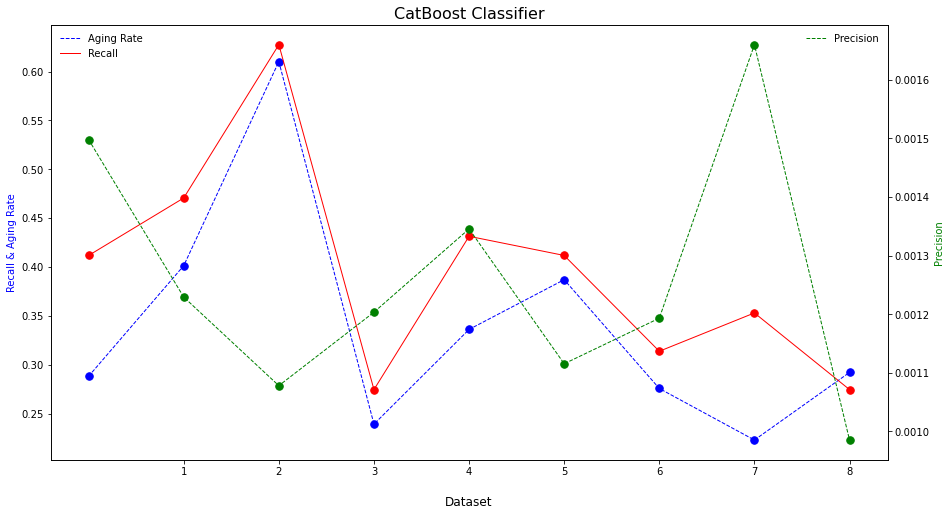

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,21.0,13997.0,30.0,34601.0,0.001498,0.411765,0.288146,1.429016,0.001493,0.365435
dataset2,1.000000,2980.0,2980.0,24.0,19500.0,27.0,29098.0,0.001229,0.470588,0.401324,1.172590,0.001226,0.365139
dataset3,1.000000,3038.0,3038.0,32.0,29651.0,19.0,18947.0,0.001078,0.627451,0.610146,1.028362,0.001076,0.443751
dataset4,1.000000,3038.0,3038.0,14.0,11619.0,37.0,36979.0,0.001203,0.274510,0.239121,1.147995,0.001198,0.209872
dataset5,1.006623,3040.0,3020.0,22.0,16327.0,29.0,32271.0,0.001346,0.431373,0.336060,1.283616,0.001341,0.356210
dataset6,1.015364,3040.0,2994.0,21.0,18805.0,30.0,29793.0,0.001115,0.411765,0.386976,1.064057,0.001112,0.298395
dataset7,1.000000,3040.0,3040.0,16.0,13393.0,35.0,35205.0,0.001193,0.313725,0.275627,1.138223,0.001189,0.238424
dataset8,1.000000,3040.0,3040.0,18.0,10825.0,33.0,37773.0,0.001660,0.352941,0.222882,1.583532,0.001652,0.334997
dataset9,10.000000,3040.0,304.0,14.0,14195.0,37.0,34403.0,0.000985,0.274510,0.292072,0.939871,0.000982,0.000000


In [6]:
line_chart(table_setC, title = 'CatBoost Classifier')
table_setC

### Export

In [7]:
savedate = '20220601'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'CatBoost'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'CatBoost')